100%|██████████| 90/90 [00:00<00:00, 366.22it/s]


ROI numbers of interest: [2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 36, 37, 38, 39, 42, 43, 44, 45, 46, 47, 48, 49, 51, 52, 53, 54, 56, 57]
Saving files to: C:/Users/shuyu/SynologyDrive/Student Data/Shuyu Li/Imaging/2025_01_20_jRGECO1a_Mutations/2025-01-20_CP_segementation_and_analysis/ROI_analysis/
File saved: C:/Users/shuyu/SynologyDrive/Student Data/Shuyu Li/Imaging/2025_01_20_jRGECO1a_Mutations/2025-01-20_CP_segementation_and_analysis/ROI_analysis//12_ROI_raw_intensity.csv
Raw fluorescence intensities saved to: C:/Users/shuyu/SynologyDrive/Student Data/Shuyu Li/Imaging/2025_01_20_jRGECO1a_Mutations/2025-01-20_CP_segementation_and_analysis/ROI_analysis//12_ROI_raw_intensity.csv
Saving files to: C:/Users/shuyu/SynologyDrive/Student Data/Shuyu Li/Imaging/2025_01_20_jRGECO1a_Mutations/2025-01-20_CP_segementation_and_analysis/ROI_analysis/
File saved: C:/Users/shuyu/SynologyDrive/Student Data/Shuyu Li/Imaging/2025_01_20_

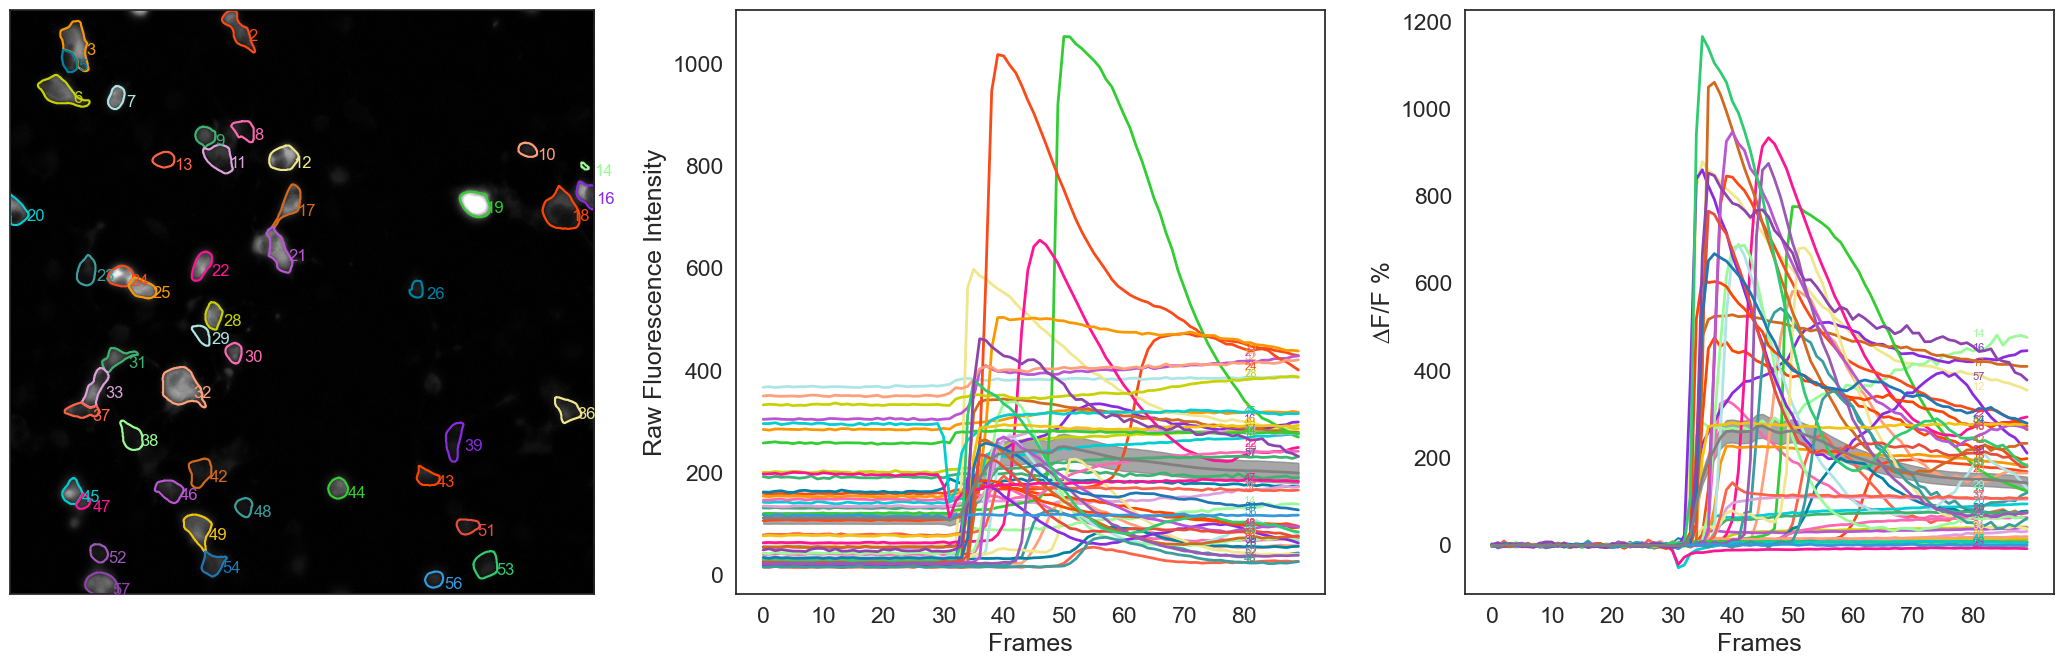

In [9]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from cellpose import utils, io
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from matplotlib import rcParams
import datetime
from matplotlib import gridspec
rcParams['font.family'] = 'DejaVu Sans'

from matplotlib.colors import LinearSegmentedColormap
GFP = [(0,0,0),(1,1,1)] #this is actually red, but I dont feel like going back and fixing it
GFP_cmap = LinearSegmentedColormap.from_list('GFP-cmap', GFP, N=256)

def load_data(base_path, sample_name):
    """Load the mask and image stack for the specified sample."""
    sample_mask_file = f"{base_path}/2025-01-20_CP_segementation_and_analysis/mask/{sample_name}_mask.npy" # change data to set the masks folder which is generated by optomass_analysis_with_cellpose_cell_segmentation_20x.ipynb!!!
    image_path = f"{base_path}/BS50/sample_{sample_name}.tif"
    post_mask = np.load(sample_mask_file)
    image_stack = io.imread(image_path)
    return post_mask, image_stack

def calculate_fluorescence(image_stack, post_mask, roi_of_interest, num_baseline_frames=20):
    """
    Calculate raw fluorescence intensities and ∆F/F₀ values for specified ROIs.
    Returns:
    - raw_intensity_df: DataFrame containing raw fluorescence intensities.
    - delta_f_over_f_df: DataFrame containing ∆F/F₀ values.
    """
    raw_intensity_df = pd.DataFrame()
    delta_f_over_f_df = pd.DataFrame()

    for roi in roi_of_interest:
        roi_intensity = []
        for frame in image_stack:
            roi_mask = post_mask == roi
            roi_intensity.append(np.round(np.mean(frame[roi_mask]), 2))
        
        raw_intensity_df[f'ROI_{roi}'] = roi_intensity
        
        baseline = np.mean(roi_intensity[:num_baseline_frames])
        delta_f_over_f = [100 * ((e - baseline) / baseline) for e in roi_intensity]
        delta_f_over_f_df[f'ROI_{roi}'] = delta_f_over_f

    raw_intensity_df.index = [f'Frame_{i}' for i in range(len(image_stack))]
    delta_f_over_f_df.index = raw_intensity_df.index
    return raw_intensity_df, delta_f_over_f_df

def save_csv(dataframe, sample_name, base_path, file_type=""):
    """
    Save the given dataframe to a CSV file.
    
    Parameters:
    - dataframe: DataFrame to save.
    - sample_name: Name of the sample (used in the file name).
    - base_path: Path where the CSV will be saved.
    - file_type: Type of the data, either "raw_intensity" or "delta_f_over_f".
    """
    date = datetime.date.today().isoformat()
    # Ensure the folder exists, create it if not
    save_folder = f"C:/Users/shuyu/SynologyDrive/Student Data/Shuyu Li/Imaging/2025_01_20_jRGECO1a_Mutations/2025-01-20_CP_segementation_and_analysis/ROI_analysis/" # change saving folder!!!
    Path(save_folder).mkdir(parents=True, exist_ok=True)
    
    # Print the folder path to confirm it's correct
    print(f"Saving files to: {save_folder}")
    
    # Define output CSV file path
    if file_type == "raw_intensity":
        output_csv = f"{save_folder}/{sample_name}_ROI_raw_intensity.csv"
    elif file_type == "delta_f_over_f":
        output_csv = f"{save_folder}/{sample_name}_ROI_delta_f_over_f.csv"
    
    # Save the DataFrame as CSV
    dataframe.to_csv(output_csv)
    print(f"File saved: {output_csv}")
    return output_csv


def plot_roi_analysis(image_stack, post_mask, roi_of_interest, raw_intensity_df, delta_f_over_f_df, sample_name):
    """
    Plot segmentation overlay, raw fluorescence intensity, and ∆F/F₀ in separate figures and combine them in a final layout.
    Show the average across all ROIs for each frame with ±10% error range as a shaded area.
    
    Parameters:
    - image_stack: Numpy array of the image stack.
    - post_mask: Numpy array of the ROI mask.
    - roi_of_interest: List of ROI numbers to analyze.
    - raw_intensity_df: DataFrame containing raw fluorescence intensities.
    - delta_f_over_f_df: DataFrame containing ∆F/F₀ values.
    - sample_name: String representing the sample name.
    """
    # Save directory for the result
    save_dir = r"C:/Users/shuyu/SynologyDrive/Student Data/Shuyu Li/Imaging/2025_01_20_jRGECO1a_Mutations/2025-01-20_CP_segementation_and_analysis/ROI_analysis" # set the results saving folder path
    Path(save_dir).mkdir(parents=True, exist_ok=True)
    save_path = f"{save_dir}/{sample_name}_roi_fluorescence_changes.pdf"

    sns.set_theme(style='white', font_scale=1.5)

    # Create a figure with three subplots arranged in a 1-row, 3-column grid
    fig = plt.figure(figsize=[21, 7])
    spec = gridspec.GridSpec(ncols=3, nrows=1, figure=fig, width_ratios=[1, 1, 1])

    # 1. Plot representative image with ROI outlines
    ax1 = fig.add_subplot(spec[0])
    rep_image = image_stack[60]  # Choose a representative image, e.g., frame 60
    ax1.imshow(rep_image, cmap=GFP_cmap, vmax=1000)
    ax1.set_xticks([]); ax1.set_yticks([])

    # Color palette for ROIs, make sure colors numbers already covered ROI numbers in a video
    color_palette = [  '#fb4918', '#fb9800', '#0082a5', '#c8d200', '#ade5e5', '#ff69b4', 
    '#3cb371', '#ffa07a', '#dda0dd', '#f0e68c', '#ff6347', '#98fb98', 
    '#8a2be2', '#d2691e', '#ff4500', '#32cd32', '#00ced1', '#ba55d3', 
    '#ff1493', '#3b9e9e', '#fb4918', '#fb9800', '#0082a5', '#c8d200', '#ade5e5', 
    '#ff69b4', '#3cb371', '#ffa07a', '#dda0dd', '#f0e68c', '#ff6347', '#98fb98', 
    '#8a2be2', '#d2691e', '#ff4500', '#32cd32', '#00ced1', '#ba55d3', 
    '#ff1493', '#3b9e9e', '#f1c40f', '#e74c3c', '#9b59b6', '#2ecc71', 
    '#1f77b4', '#3498db', '#8e44ad', '#16a085', '#e67e22', '#d35400', 
    '#f39c12', '#c0392b', '#27ae60', '#2980b9', '#34495e', '#7f8c8d', 
    '#d5dbdb', '#f5b7b1', '#ab7b88', '#f5cba7', '#16a085', '#1abc9c', 
    '#9b59b6', '#3498db', '#8e44ad', '#e74c3c', '#e67e22', '#2ecc71', 
    '#1f77b4', '#9b59b6', '#f1c40f', '#9a12b3', '#3b97ff', '#f06c48', 
    '#58d68d', '#82e0aa', '#1f8b65', '#ac0b72', '#7d18c4', '#b8d6ed', 
    '#f39c12', '#d35400', '#e74c3c', '#16a085', '#1abc9c', '#9b59b6', 
    '#3498db', '#8e44ad', '#f39c12', '#c0392b', '#27ae60', '#2980b9', 
    '#34495e', '#7f8c8d', '#f5b7b1', '#d5dbdb', '#f5cba7', '#16a085', 
    '#1abc9c', '#9b59b6', '#3498db', '#8e44ad', '#e74c3c', '#e67e22', 
    '#2ecc71', '#1f77b4', '#9b59b6', '#f1c40f', '#9a12b3', '#3b97ff']

    # Plot ROI outlines on the representative image
    for i, roi in enumerate(roi_of_interest):
        roi_mask = post_mask == roi
        outlines = utils.outlines_list(roi_mask.astype(np.int32))
        color = color_palette[i]
        for o in outlines:
            o_x = [e[0] for e in o]
            o_y = [e[1] for e in o]
            ax1.text(np.mean(o_x) + 20, np.mean(o_y) + 20, str(roi), color=color, fontsize=12)
            ax1.plot(o[:, 0], o[:, 1], color=color, linewidth=1.5)

    # 2. Plot raw fluorescence intensity dynamics with average and error range as shaded area
    ax2 = fig.add_subplot(spec[1])
    avg_raw_intensity = raw_intensity_df.mean(axis=1)  # Calculate the average across all ROIs for each frame
    error_raw_intensity = avg_raw_intensity * 0.1  # ±10% error
    
    # Plot the raw intensity curve for all ROIs
    for i, roi in enumerate(roi_of_interest):
        sns.lineplot(data=raw_intensity_df[f'ROI_{roi}'], color=color_palette[i], linestyle="-", linewidth=2, ax=ax2)
        
        # Add ROI number next to the curve (smaller font size)
        ax2.text(len(raw_intensity_df) - 10, raw_intensity_df[f'ROI_{roi}'].iloc[-1], str(roi), color=color_palette[i], fontsize=8)

    # Plot the average raw intensity curve
    ax2.plot(avg_raw_intensity, label="Average (Raw Intensity)", color='grey', linewidth=2)

    # Fill the shaded area for ±10% error range around the average intensity curve
    ax2.fill_between(range(len(avg_raw_intensity)), avg_raw_intensity - error_raw_intensity, avg_raw_intensity + error_raw_intensity, color='gray', alpha=0.7,label='±10% Range')

    # Set x-ticks every 10 frames
    ax2.set_xticks(np.arange(0, len(avg_raw_intensity), 10))
    ax2.set_xticklabels(np.arange(0, len(avg_raw_intensity), 10))

    ax2.set_xlabel('Frames')
    ax2.set_ylabel('Raw Fluorescence Intensity')

    # 3. Plot delta F/F₀ dynamics with average and error range as shaded area
    ax3 = fig.add_subplot(spec[2])
    avg_delta_f_over_f = delta_f_over_f_df.mean(axis=1)  # Calculate the average across all ROIs for each frame
    error_delta_f_over_f = avg_delta_f_over_f * 0.1  # ±10% error
    
    # Plot the delta F/F₀ curve for all ROIs
    for i, roi in enumerate(roi_of_interest):
        sns.lineplot(data=delta_f_over_f_df[f'ROI_{roi}'], color=color_palette[i], linestyle="-",linewidth=2, ax=ax3)
        
        # Add ROI number next to the curve (smaller font size)
        ax3.text(len(delta_f_over_f_df) - 10, delta_f_over_f_df[f'ROI_{roi}'].iloc[-1], str(roi), color=color_palette[i], fontsize=8)

    # Plot the average delta F/F₀ curve
    ax3.plot(avg_delta_f_over_f, label="Average (∆F/F)", color='grey', linewidth=2)

    # Fill the shaded area for ±10% error range around the average ∆F/F₀ curve
    ax3.fill_between(range(len(avg_delta_f_over_f)), avg_delta_f_over_f - error_delta_f_over_f, avg_delta_f_over_f + error_delta_f_over_f, color='gray', alpha=0.7,label='±10% Range')

    # Set x-ticks every 10 frames
    ax3.set_xticks(np.arange(0, len(avg_delta_f_over_f), 10))
    ax3.set_xticklabels(np.arange(0, len(avg_delta_f_over_f), 10))

    ax3.set_xlabel('Frames')
    ax3.set_ylabel('∆F/F %')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    # Save the combined figure to the specified path
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()


def main():
    #base_path = input("Enter the base path: ").strip()
    base_path = "C:/Users/shuyu/SynologyDrive/Student Data/Shuyu Li/Imaging/2025_01_20_jRGECO1a_Mutations/" # change base path!!!
    sample_name = input("Input the sample number (eg. 08): ").strip()

    post_mask, image_stack = load_data(base_path, sample_name)

    # Input the ROI numbers to exclude
    roi_of_uninterest_input = input("Input the ROI numbers to exclude (eg. 1,2,3,4,5): ").strip()
    roi_of_uninterest = [int(roi.strip()) for roi in roi_of_uninterest_input.split(",") if roi.strip().isdigit()]

    all_roi = list(range(1, np.max(post_mask) + 1))
    roi_of_interest = [roi for roi in all_roi if roi not in roi_of_uninterest]

    print(f"ROI numbers of interest: {roi_of_interest}")

    # Calculate raw fluorescence intensities and ∆F/F₀
    raw_intensity_df, delta_f_over_f_df = calculate_fluorescence(image_stack, post_mask, roi_of_interest)
    
    # Save raw fluorescence intensities to CSV
    raw_intensity_csv = save_csv(raw_intensity_df, sample_name, base_path, file_type="raw_intensity")
    print(f"Raw fluorescence intensities saved to: {raw_intensity_csv}")
    
    # Save delta F/F₀ values to CSV
    delta_f_csv = save_csv(delta_f_over_f_df, sample_name, base_path, file_type="delta_f_over_f")
    print(f"Delta F/F₀ values saved to: {delta_f_csv}")
    
    # Plot and save ROI analysis
    plot_roi_analysis(image_stack, post_mask, roi_of_interest, raw_intensity_df, delta_f_over_f_df, sample_name)
    
if __name__ == "__main__":
    main()
